In [1]:
import os
os.chdir('../../..')

In [2]:
import convokit
from convokit import Corpus

In [3]:
os.chdir('convokit/thread_generator')

In [4]:
from convokit.thread_generator import ThreadSpawner

In [7]:
def recip_lambda(k):
    if k <= 15:
        return 0.25
    else:
        return 0.9


# becomes very reciprocal
t_spawner1 = ThreadSpawner(participant_factor=20, recip_factor=recip_lambda, expansion_factor=lambda k: 0.5)
utts = t_spawner1.spawn_thread(thread_index=1, length=25)
for idx, utt in enumerate(utts):
    utt.meta['order'] = idx + 1
    utt.meta['class'] = 1
Corpus(utterances=utts).get_conversation('1-1').print_conversation_structure(lambda utt: str(utt.meta['order']) + ". " + utt.user.id)

1. 0x1
    2. 0x2
        3. 0x1
            14. 0x3
                15. 0x16
                    16. 0x3
                        17. 0x16
                            18. 0x3
                                19. 0x16
                                    20. 0x3
                                        21. 0x16
                                            22. 0x3
                                                23. 0x16
        5. 0x27
            12. 0x15
            24. 0x24
                25. 0x16
    4. 0x25
        6. 0x26
        9. 0x19
    7. 0x15
    8. 0x27
    10. 0x1a
        11. 0x7
    13. 0x16


In [8]:
def recip_lambda(k):
    if k <= 15:
        return 0.25
    else:
        return 0.1

t_spawner2 = ThreadSpawner(participant_factor=20, recip_factor=recip_lambda, 
                           expansion_factor=lambda k: 0.5)
utts = t_spawner2.spawn_thread(thread_index=1, length=25)
for idx, utt in enumerate(utts):
    utt.meta['order'] = idx + 1
    utt.meta['class'] = 2
Corpus(utterances=utts).get_conversation('1-1').print_conversation_structure(lambda utt: str(utt.meta['order']) + ". " + utt.user.id)

1. 0x1
    2. 0x2
        3. 0x1
            4. 0x1a
                13. 0xe
                    14. 0xf
                        15. 0xe
    5. 0x14
    6. 0x20
        7. 0x2
        21. 0x13
    8. 0xf
        19. 0x11
    9. 0x28
        10. 0xf
            16. 0x1
                17. 0x20
                18. 0xa
        25. 0x12
    11. 0xc
        12. 0xf
    20. 0x1c
    22. 0x11
        23. 0x14
    24. 0x1a


In [9]:
# constant
t_spawner3 = ThreadSpawner(participant_factor=20, recip_factor=lambda k: 0.25, expansion_factor=lambda k: 0.5)
utts = t_spawner3.spawn_thread(thread_index=1, length=25)
for idx, utt in enumerate(utts):
    utt.meta['order'] = idx + 1
    utt.meta['class'] = 3
Corpus(utterances=utts).get_conversation('1-1').print_conversation_structure(lambda utt: str(utt.meta['order']) + ". " + utt.user.id)    

1. 0x1
    2. 0x2
        11. 0x16
    3. 0xc
    4. 0x16
        5. 0xc
            24. 0x11
    6. 0x24
        7. 0xc
            8. 0x24
                9. 0x11
                    22. 0x15
                        23. 0x22
                10. 0xe
    12. 0x27
        13. 0x16
        17. 0x1f
    14. 0x1d
    15. 0x15
        21. 0x22
    16. 0x1b
    18. 0x12
        19. 0x1f
            20. 0x12
    25. 0x8


## Corpus generation

In [11]:
all_utts = []

In [12]:
group_size = 1000

In [13]:
LENGTH=25
for thread_idx in range(1, group_size+1):
    utts = t_spawner1.spawn_thread(thread_idx, length=LENGTH)
    for utt in utts: utt.meta['subreddit'] = '1.rising'
    all_utts.extend(utts)

for thread_idx in range(group_size+1, 2*group_size+1):
    utts = t_spawner2.spawn_thread(thread_idx, length=LENGTH)
    for utt in utts: utt.meta['subreddit'] = '2.decreasing'
    all_utts.extend(utts)
    
for thread_idx in range(2*group_size+1, 3*group_size+1):
    utts = t_spawner3.spawn_thread(thread_idx, length=LENGTH)
    for utt in utts: utt.meta['subreddit'] = '3.static'
    all_utts.extend(utts)


In [14]:
len(all_utts)

75000

In [15]:
corpus = Corpus(utterances=all_utts)

In [16]:
corpus.print_summary_stats()

Number of Speakers: 40
Number of Utterances: 75000
Number of Conversations: 3000


In [148]:
from functools import reduce

In [149]:
for convo in corpus.iter_conversations():
    convo.meta['prob'] = reduce(lambda x, y: x * y, [utt.meta['prob'] for utt in convo.iter_utterances()])

In [17]:
from convokit import HyperConvo

In [18]:
hc20 = HyperConvo(prefix_len=20, feat_name='hyperconvo-20', invalid_val=-1)

In [19]:
hc20.fit_transform(corpus)

In [20]:
for convo in corpus.iter_conversations():
    convo.meta['group'] = int(next(convo.iter_utterances()).meta['subreddit'][0])

In [26]:
import pandas as pd
df = corpus.get_conversations_dataframe()
df_subset = df[['meta.group', 'meta.hyperconvo-20']]
hc_dicts = {df_subset.iloc[idx].name: df_subset.iloc[idx]['meta.hyperconvo-20'] for idx in range(len(df_subset))}
df_hc = pd.DataFrame(hc_dicts).T.astype('float64')
df_combi_20 = pd.concat([df_subset, df_hc], axis=1, sort=False)

In [27]:
means_20 = df_combi_20.groupby('meta.group').mean() #.to_csv('~/Desktop/agg_means.csv')
# percent_diff = (means.iloc[0] - means.iloc[1])*2 / (means.iloc[0] + means.iloc[1] + 0.00001)
# sum(percent_diff)
means_20[['count[reciprocity motif]']]

,count[reciprocity motif]
meta.group,
1,5.191
2,1.851
3,2.139


In [28]:
means_20

,2nd-argmax[indegree over C->C mid-thread responses],2nd-argmax[indegree over C->C responses],2nd-argmax[indegree over C->c mid-thread responses],2nd-argmax[indegree over C->c responses],2nd-argmax[indegree over c->c mid-thread responses],2nd-argmax[indegree over c->c responses],2nd-argmax[outdegree over C->C mid-thread responses],2nd-argmax[outdegree over C->C responses],2nd-argmax[outdegree over C->c mid-thread responses],2nd-argmax[outdegree over C->c responses],...,prop-nonzero[indegree over C->C mid-thread responses],prop-nonzero[indegree over C->C responses],prop-nonzero[indegree over C->c mid-thread responses],prop-nonzero[indegree over C->c responses],prop-nonzero[indegree over c->c mid-thread responses],prop-nonzero[indegree over c->c responses],prop-nonzero[outdegree over C->C mid-thread responses],prop-nonzero[outdegree over C->C responses],prop-nonzero[outdegree over C->c mid-thread responses],prop-nonzero[outdegree over C->c responses]
meta.group,,,,,,,,,,,,,,,,,,,,,
1,2.379,1.991,4.639,3.139,4.639,3.139,4.646,4.536,5.969,6.726,...,0.712975,0.738146,0.585105,0.60585,0.585105,0.60585,0.705641,0.947024,0.705641,0.947024
2,2.452,2.375,3.849,3.360,3.849,3.360,3.913,3.898,3.814,3.811,...,0.538523,0.568638,0.446789,0.47445,0.446789,0.47445,0.653032,0.962562,0.653032,0.962562
3,2.253,2.237,3.828,3.433,3.828,3.433,4.365,4.236,4.268,4.211,...,0.583851,0.609629,0.469842,0.49635,0.469842,0.49635,0.671434,0.960766,0.671434,0.960766


## Defining classification task

In [21]:
hc25 = HyperConvo(prefix_len=25, feat_name='hyperconvo-25', invalid_val=-1)

In [22]:
hc25.fit_transform(corpus)

In [29]:
df = corpus.get_conversations_dataframe()
df_subset = df[['meta.group', 'meta.hyperconvo-25']]
hc_dicts = {df_subset.iloc[idx].name: df_subset.iloc[idx]['meta.hyperconvo-25'] for idx in range(len(df_subset))}
df_hc = pd.DataFrame(hc_dicts).T.astype('float64')
df_combi_25 = pd.concat([df_subset, df_hc], axis=1, sort=False)

In [31]:
means_25 = df_combi_25.groupby('meta.group').mean() #.to_csv('~/Desktop/agg_means.csv')
# percent_diff = (means.iloc[0] - means.iloc[1])*2 / (means.iloc[0] + means.iloc[1] + 0.00001)
# sum(percent_diff)
means_25[['count[reciprocity motif]']]

,count[reciprocity motif]
meta.group,
1,9.335
2,2.014
3,2.607


In [32]:
df_compare = df_combi_20[['meta.group', 'count[reciprocity motif]']]

In [33]:
df_compare['reciprocity-25'] = df_combi_25['count[reciprocity motif]']

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [34]:
df_compare['reciprocity-20'] = df_compare['count[reciprocity motif]']

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [35]:
del df_compare['count[reciprocity motif]']

In [36]:
df_compare['recip_div'] = df_compare['reciprocity-25'] / df_compare['reciprocity-20']

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [42]:
df_compare = df_compare.fillna(0)

In [43]:
df_compare['recip_div_bool'] = df_compare['recip_div'] >= 1.5

In [44]:
df_compare.groupby('meta.group').mean()

,reciprocity-25,reciprocity-20,recip_div,recip_div_bool
meta.group,,,,
1,9.335,5.191,1.91641,0.886
2,2.014,1.851,inf,0.103
3,2.607,2.139,inf,0.245


In [45]:
df_compare['recip_diff'] = df_compare['reciprocity-25'] - df_compare['reciprocity-20']

In [50]:
df_compare['recip_diff_bool'] = df_compare['recip_diff'] >= 3.0

In [51]:
df_compare.groupby('meta.group').mean()

,reciprocity-25,reciprocity-20,recip_div,recip_div_bool,recip_diff,recip_diff_bool
meta.group,,,,,,
1,9.335,5.191,1.91641,0.886,4.144,0.922
2,2.014,1.851,inf,0.103,0.163,0.003
3,2.607,2.139,inf,0.245,0.468,0.012


In [24]:
hyperconv_range = range(2, 20)

In [52]:
for hc_idx in hyperconv_range:
    hc = HyperConvo(prefix_len=hc_idx, feat_name="hyperconvo-{}".format(hc_idx), invalid_val=-1)
    hc.fit_transform(corpus)

In [53]:
corpus.dump('annotated-fake-trajectory-experiment-2', base_path='.')

## Quantize(?) the probs

In [26]:
from collections import defaultdict
from sklearn.preprocessing import QuantileTransformer
import numpy as np

In [27]:
probs = defaultdict(list)
for convo in corpus.iter_conversations():
    probs[convo.meta['group']].append(convo.meta['prob'])

In [28]:
import seaborn as sns

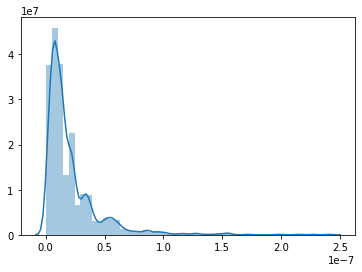

In [29]:
sns.distplot(probs[1])

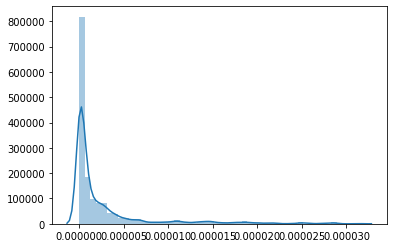

In [30]:
sns.distplot(probs[2])

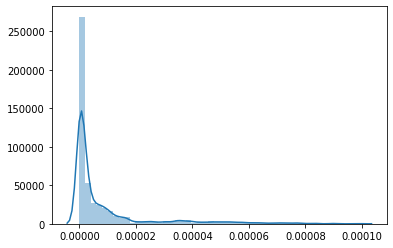

In [31]:
sns.distplot(probs[3])

In [32]:
qt = QuantileTransformer(n_quantiles=18)

In [33]:
percentiles = defaultdict(list)
for k, v in probs.items():
    probs[k] = np.array(v).reshape(-1, 1)
    mm = QuantileTransformer(n_quantiles=18)
    percentiles[k] = mm.fit_transform(probs[k])

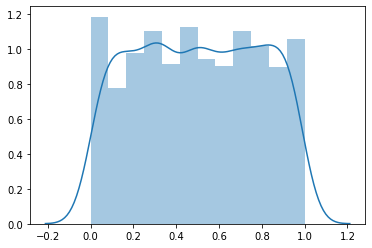

In [34]:
sns.distplot(qt.fit_transform(probs[1]))

In [ ]:
for idx, convo in enumerate(corpus.iter_conversations()):
    convo.meta['percentile'] = percentiles[convo.meta['group']][idx % 333][0]

In [ ]:
next(corpus.iter_conversations()).meta['percentile']

In [35]:
from convokit import HyperConvo

In [ ]:
# corpus = Corpus(filename='annotated-fake-trajectory-2')

In [ ]:
corpus.dump('annotated-fake-trajectory-experiment', base_path='.')

In [ ]:
# corpus = Corpus(filename='annotated-fake-trajectory-4')

In [38]:
import pandas as pd
df = corpus.get_conversations_dataframe()
df_subset = df[['meta.group', 'meta.hyperconvo-20']]
hc_dicts = {df_subset.iloc[idx].name: df_subset.iloc[idx]['meta.hyperconvo-20'] for idx in range(len(df_subset))}
df_hc = pd.DataFrame(hc_dicts).T.astype('float64')
df_combi = pd.concat([df_subset, df_hc], axis=1, sort=False)

In [40]:
means = df_combi.groupby('meta.group').mean() #.to_csv('~/Desktop/agg_means.csv')
# percent_diff = (means.iloc[0] - means.iloc[1])*2 / (means.iloc[0] + means.iloc[1] + 0.00001)
# sum(percent_diff)
means[['count[reciprocity motif]']]

,count[reciprocity motif]
meta.group,
1,2.710000
2,3.358667
3,4.156000


In [ ]:
pd.set_option("display.max_rows", None)

In [ ]:
percent_diff.sort_values()

In [ ]:
np.sum(np.sum(pd.isnull(percent_diff))) # NaN values

In [ ]:
from convokit import Utterance, Speaker

In [ ]:
not_json_serializable = np.uint64('99')

In [ ]:
import json

with open('tester.json', 'w') as f:
    json.dump(not_json_serializable, f)

In [ ]:
cp = Corpus(utterances=[Utterance(id='1', speaker=Speaker(id='hi'), meta={'binary': np.uint64('99')})])

In [ ]:
cp.view_utterances()